# Importing neccesary python modules

In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
! pip install feature_engine
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.seasonal import seasonal_decompose
from plotly.subplots import make_subplots
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from datetime import datetime
from datetime import timedelta
from sklearn.metrics import mean_squared_error

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 276 kB 31.5 MB/s 
     |████████████████████████████████| 9.8 MB 30.4 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


# Importing Dataset

In [2]:
# To Import Data from google drive (authentication needed)
from google.colab import drive 
drive.mount('/content/gdrive')
data=pd.read_csv('gdrive/My Drive/Personal Data Science Projects/Apple Stocks Predictions/AAPL.csv', parse_dates=['Date'])

Mounted at /content/gdrive


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3126 entries, 0 to 3125
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       3126 non-null   datetime64[ns]
 1   Open       3126 non-null   float64       
 2   High       3126 non-null   float64       
 3   Low        3126 non-null   float64       
 4   Close      3126 non-null   float64       
 5   Adj Close  3126 non-null   float64       
 6   Volume     3126 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 171.1 KB


In [4]:
data.set_index('Date',inplace=True)
Data = data[['Close']]
Data

,Close
Date,
2010-01-04,7.643214
2010-01-05,7.656429
2010-01-06,7.534643
2010-01-07,7.520714
2010-01-08,7.570714
...,...
2022-05-26,143.779999
2022-05-27,149.639999
2022-05-31,148.839996


In [5]:
Data.isnull().sum()

Close    0
dtype: int64

# Visualization of Stock Price (Closing Price)

In [6]:
fig = px.line( x=Data.index , y=Data['Close'] )
fig.update_layout( yaxis_title='Close Price' )
fig.show()

# Simple Moving Average

In [7]:
MA_df = pd.DataFrame( columns=['days_20','days_50','days_200'] ) # Commonly used periods are 20-day, 50-day, and 200-day MA for short-term, medium-term, and long-term investment respectively. 
i = 0
fig = go.Figure()
fig.add_trace( go.Scatter( x = Data.index, y = Data['Close'], name="Original" ) )
days = [20,50,100]
for lag_col in list(MA_df.columns.values):
  MA_df[lag_col] =  Data['Close'].rolling( window=days[i] ).mean()
  fig.add_trace( go.Scatter( x=MA_df.index, y=MA_df[lag_col], name= lag_col ) )
  i=i+1
fig.update_layout( width=2000,height=1000 )
fig.show()

***


# Exponential Moving Average (50 days)

In [8]:
EMA_df = pd.DataFrame( columns=['days_20','days_50','days_200'] ) #Commonly used periods are 20-day, 50-day, and 200-day MA for short-term, medium-term, and long-term investment respectively. 
i = 0
fig = go.Figure()
fig.add_trace( go.Scatter( x = Data.index, y = Data['Close'], name="Original" ) )
window_size = [20,50,100]
for lag_col in list(EMA_df.columns.values):
  EMA_df[lag_col] =  Data['Close'].ewm( span=window_size[i] ).mean()
  fig.add_trace( go.Scatter( x=EMA_df.index, y=EMA_df[lag_col], name= lag_col ) )
  i=i+1
fig.update_layout( width=1800,height=1000 )
fig.show()

# Comparison of SMA and EMA 

In [9]:
fig = go.Figure()
fig.add_trace( go.Scatter( x = Data.index, y = Data['Close'], name="Original" ) )
fig.add_trace( go.Scatter( x=EMA_df.index, y=EMA_df['days_50'], name= "EMA Days_50" ) )
fig.add_trace( go.Scatter( x=MA_df.index, y=MA_df['days_50'], name= "SMA Days_50" ) )
fig.update_layout( width=1800,height=1000 )

Performance of EMA is little better than SMA ( as EMA captures ups and downs using lesser number of lags  )
***

# Seasonal Decompositiion

In [10]:
result_sd_mul = seasonal_decompose( Data['Close'], model='mul', period=365 )

fig = make_subplots( 4,1 )
fig.add_trace(go.Scatter( x = Data.index , y = Data['Close'], mode='lines' , name = "Observed (Closing Price)"), row=1,col=1 )
fig.add_trace(go.Scatter( x = Data.index , y = result_sd_mul.trend , mode='lines' , name='Trend (freq = 365 days)'), row=2,col=1  )
fig.add_trace(go.Scatter( x = Data.index , y = result_sd_mul.seasonal , mode='lines', name='Seasonal (freq = 365 days)' ), row=3,col=1  )
fig.add_trace(go.Scatter( x = Data.index , y = result_sd_mul.resid , mode='lines' , name='Residual (freq = 365 days)' ), row=4,col=1  )
fig.update_layout(title='Seasonal Decompose', height=1200)
fig.show()

In [11]:
# Future Dates ( For Forecasting )
future = 30 # days
future_dates = []
for i in range( 30 ):
  future_dates.append( Data.index[-1] + timedelta(days=i+1) )

Level : Present <br>
Trend : Present <br>
Seasonality : Present <br>
Nosie : Present <br>
***
Smoothing Function to be used : Triple Exponential Smoothing (Holt-Winters' Method)
***

# Triple Exponential Smoothing (Holt-Winters' Method)

In [12]:
! pip install statsmodel
from statsmodels.tsa.holtwinters import ExponentialSmoothing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement statsmodel (from versions: none)
ERROR: No matching distribution found for statsmodel


In [13]:
fit_1 = ExponentialSmoothing( data['Close'], seasonal_periods=30, trend='mul', seasonal='add', use_boxcox=True ).fit()
fit_2 = ExponentialSmoothing( data['Close'], seasonal_periods=30, trend='mul', seasonal='mul', use_boxcox=True ).fit()
fig = go.Figure()
fig.add_trace( go.Scatter( x = Data.index, y = Data['Close'], name="Original" ) )
forecast_1 = fit_1.forecast(30)
forecast_2 = fit_2.forecast(30)

fig.add_trace( go.Scatter( x=future_dates, y=forecast_1, name= "ExponentialSmoothing_Mul_Mul" ) )
fig.add_trace( go.Scatter( x=future_dates, y=forecast_2, name= "ExponentialSmoothing_Mul_Add" ) )
fig.update_layout( xaxis_title='Date ---->', yaxis_title="CLose_Price ---->" )

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning:

overflow encountered in matmul

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



In [14]:
model_mul = ExponentialSmoothing( Data['Close'], trend='mul',seasonal='mul', seasonal_periods=30 ) # Triple Exponential Fucntion
results_mul = model_mul.fit()
predictions_mul = results_mul.forecast(steps= future )

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning:

overflow encountered in matmul

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



In [15]:
triple_ES_pred = pd.DataFrame(columns=['Future Dates', 'Predicted Closed Price'])
triple_ES_pred['Future Dates']=future_dates
triple_ES_pred['Predicted Closed Price'] = predictions_mul.values
triple_ES_pred

,Future Dates,Predicted Closed Price
0,2022-06-03,151.839457
1,2022-06-04,151.115794
2,2022-06-05,150.282218
3,2022-06-06,150.697420
4,2022-06-07,151.242394
5,2022-06-08,151.508581
6,2022-06-09,151.618058
7,2022-06-10,152.076078
8,2022-06-11,152.666334
9,2022-06-12,153.196755


In [16]:
fig = go.Figure()
fig.add_trace( go.Scatter(x=Data.index, y=Data['Close'], name="Actual Close Price" ))
fig.add_trace( go.Scatter(x=future_dates, y=predictions_mul, name="Predicted Close Price ( Triple Exponential )" ) )
fig.show()

# Stationarity Test


##### Result : Both tests conclude that the series is not stationary - The series is not stationary

In [17]:
# ADF stationarity test
# Returns: {Test statistic, P-value, Num lags used, {Critical values}, Estmation of maximized information criteria}
adfuller_result = adfuller(Data['Close'])
p_value = adfuller_result[1]
p_value
# Fail to Reject the null hypothesis | Data is Non-Stationary

0.9961974106631288

In [18]:
# Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test
result_kpss = kpss( Data["Close"] )
p_value = result_kpss[1]
p_value
# Fail to Reject the null hypothesis | Data is Non-Stationary

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




0.01

# Converting Non Stationary Data into Stationary Data
### Log function is applied



In [19]:
# Converting Non Stationary Data into Stationary Data
Close_diff = pd.Series( np.log( Data['Close'] )).diff()
Close_diff = Close_diff[1:]

In [20]:
# ADF stationarity test
# Returns: {Test statistic, P-value, Num lags used, {Critical values}, Estmation of maximized information criteria}

adfuller_result = adfuller(Close_diff)
p_value = adfuller_result[1]
p_value

# Reject the null hypothesis | Data is Stationary

3.651149169239707e-21

In [21]:
# Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test

result_kpss = kpss( Close_diff )
p_value = result_kpss[1]
p_value

# Reject the null hypothesis | Data is Stationary

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




0.1

In [22]:
fig = px.line( x = Close_diff.index, y = Close_diff )
fig.show()

In [23]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



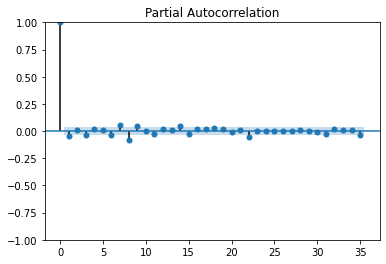

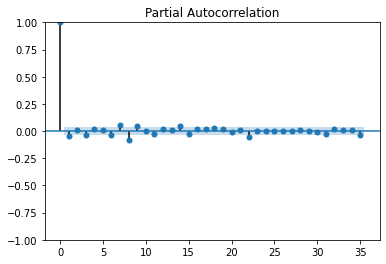

In [24]:
plot_pacf( Close_diff ) 

#### Both the plots are same

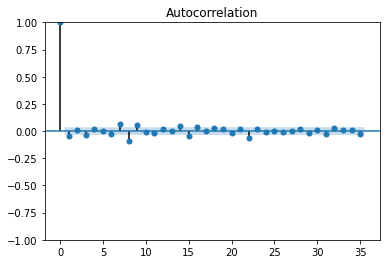

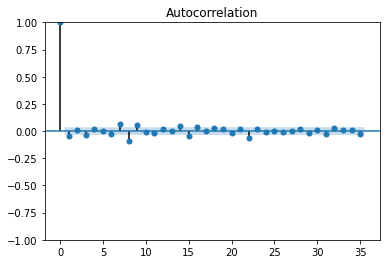

In [25]:
plot_acf(Close_diff)

* ACF and PACF drop instantly (no significant lags), it difficult to guess order and  maybe time series model cannot be build

# AutoArima

In [26]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 15.9 MB/s 


In [27]:
# from pmdarima.arima import auto_arima
# arima_model = auto_arima( np.float16(Data['Close']) , 
#                           start_p=2, d=None, start_q=1, max_p=3, max_d=3, max_q=3,
#                           start_P=2, D=1, start_Q=1, max_P=3, max_Q=3,
#                           m=12, seasonal=True,
#                           random_state=10, n_fits=5, stepwise=True, test='adf',
#                           trace=True, error_action='ignore', suppress_warnings=True)

In [28]:
# Performing stepwise search to minimize aic
#  ARIMA(2,0,1)(2,1,1)[12] intercept   : AIC=inf, Time=97.44 sec
#  ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=17485.293, Time=0.25 sec
#  ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=11406.456, Time=5.86 sec
#  ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=14927.598, Time=5.21 sec
#  ARIMA(0,0,0)(0,1,0)[12]             : AIC=17536.697, Time=0.19 sec
#  ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=12184.557, Time=0.76 sec
#  ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=11022.969, Time=19.35 sec
#  ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=10838.182, Time=35.29 sec
#  ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=103.91 sec
#  ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=63.45 sec
#  ARIMA(0,0,0)(3,1,0)[12] intercept   : AIC=17468.121, Time=19.05 sec
#  ARIMA(2,0,0)(3,1,0)[12] intercept   : AIC=10831.883, Time=40.35 sec
#  ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=11017.323, Time=22.56 sec
#  ARIMA(2,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=128.21 sec
#  ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=78.12 sec
#  ARIMA(3,0,0)(3,1,0)[12] intercept   : AIC=10833.698, Time=56.51 sec
#  ARIMA(2,0,1)(3,1,0)[12] intercept   : AIC=10832.275, Time=99.75 sec
#  ARIMA(1,0,1)(3,1,0)[12] intercept   : AIC=10832.009, Time=41.97 sec

In [29]:
# from pmdarima.arima import auto_arima
# arima_model = auto_arima( np.float16(Data['Close']) , 
#                           start_p=1, d=None, start_q=1, max_p=3, max_d=3, max_q=3,
#                           start_P=1, D=1, start_Q=1, max_P=3, max_Q=3,
#                           m=12, seasonal=True,
#                           random_state=10, n_fits=5, stepwise=True, test='adf',
#                           trace=True, error_action='ignore', suppress_warnings=True)

In [30]:
# Performing stepwise search to minimize aic
#  ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=62.57 sec
#  ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=17485.293, Time=0.64 sec
#  ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=11406.456, Time=11.24 sec
#  ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=14927.598, Time=5.76 sec
#  ARIMA(0,0,0)(0,1,0)[12]             : AIC=17536.697, Time=0.15 sec
#  ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=12184.557, Time=0.77 sec
#  ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=11022.969, Time=18.86 sec
#  ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=10838.182, Time=37.27 sec
#  ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=101.05 sec
#  ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=65.11 sec
#  ARIMA(0,0,0)(3,1,0)[12] intercept   : AIC=17468.121, Time=19.35 sec
#  ARIMA(2,0,0)(3,1,0)[12] intercept   : AIC=10831.883, Time=41.15 sec
#  ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=11017.323, Time=22.31 sec
#  ARIMA(2,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=128.03 sec
#  ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=77.18 sec
#  ARIMA(3,0,0)(3,1,0)[12] intercept   : AIC=10833.698, Time=52.99 sec
#  ARIMA(2,0,1)(3,1,0)[12] intercept   : AIC=10832.275, Time=87.84 sec
#  ARIMA(1,0,1)(3,1,0)[12] intercept   : AIC=10832.009, Time=42.52 sec
#  ARIMA(3,0,1)(3,1,0)[12] intercept   : AIC=10834.271, Time=87.20 sec

In [31]:
# Best Model | ARIMA(2,0,0)(3,1,0)[12] has **minimum** AIC (i.e  AIC = 10831.883 ) 

In [32]:
# Performing stepwise search to minimize aic
#  ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=45.55 sec
#  ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=17485.293, Time=0.21 sec
#  ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=11406.456, Time=5.81 sec
#  ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=14927.598, Time=5.02 sec
#  ARIMA(0,0,0)(0,1,0)[12]             : AIC=17536.697, Time=0.16 sec
#  ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=12184.557, Time=0.75 sec
#  ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=11022.969, Time=18.25 sec
#  ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=10838.182, Time=33.48 sec
#  ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=98.63 sec
#  ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=62.85 sec
#  ARIMA(0,0,0)(3,1,0)[12] intercept   : AIC=17468.121, Time=18.74 sec
#  ARIMA(2,0,0)(3,1,0)[12] intercept   : AIC=10831.883, Time=38.33 sec
#  ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=11017.323, Time=21.96 sec
#  ARIMA(2,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=123.21 sec
#  ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=75.80 sec
#  ARIMA(3,0,0)(3,1,0)[12] intercept   : AIC=10833.698, Time=55.62 sec
#  ARIMA(2,0,1)(3,1,0)[12] intercept   : AIC=10832.275, Time=86.21 sec
#  ARIMA(1,0,1)(3,1,0)[12] intercept   : AIC=10832.009, Time=39.73 sec
#  ARIMA(3,0,1)(3,1,0)[12] intercept   : AIC=10834.271, Time=83.28 sec

In [33]:
# from pmdarima.arima import auto_arima
# arima_model = auto_arima( np.float16(Data['Close']) , 
#                           start_p=1, d=None, start_q=1, max_p=4, max_d=3, max_q=4,
#                            D=1, Q=0, P=4,
#                           m=12, seasonal=True,
#                           random_state=10, n_fits=5, stepwise=True, test='adf',
#                           trace=True, error_action='ignore', suppress_warnings=True)

In [34]:
# Performing stepwise search to minimize aic
#  ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=30.04 sec
#  ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=17485.293, Time=0.16 sec
#  ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=11406.456, Time=5.17 sec
#  ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=14927.598, Time=4.46 sec
#  ARIMA(0,0,0)(0,1,0)[12]             : AIC=17536.697, Time=0.12 sec
#  ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=12184.557, Time=0.62 sec
#  ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=11022.969, Time=16.55 sec
#  ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=57.88 sec
#  ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=26.32 sec
#  ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=17466.160, Time=7.97 sec
#  ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=11017.323, Time=19.67 sec
#  ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=11401.077, Time=6.82 sec
#  ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=70.13 sec
#  ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=43.02 sec
#  ARIMA(3,0,0)(2,1,0)[12] intercept   : AIC=11019.055, Time=25.81 sec
#  ARIMA(2,0,1)(2,1,0)[12] intercept   : AIC=11017.326, Time=36.89 sec
#  ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=11017.467, Time=21.14 sec
#  ARIMA(3,0,1)(2,1,0)[12] intercept   : AIC=11019.324, Time=42.49 sec
#  ARIMA(2,0,0)(2,1,0)[12]             : AIC=11017.809, Time=5.23 sec

# Best model:  ARIMA(2,0,0)(2,1,0)[12] intercept
# Total fit time: 420.566 seconds

In [35]:
# Performing stepwise search to minimize aic
#  ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=17485.293, Time=0.30 sec
#  ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=11406.456, Time=9.80 sec
#  ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=14927.598, Time=9.51 sec
#  ARIMA(0,0,0)(0,1,0)[12]             : AIC=17536.697, Time=0.46 sec
#  ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=12184.557, Time=1.97 sec
#  ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=11022.969, Time=25.44 sec
#  ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=10838.182, Time=33.47 sec
#  ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=123.25 sec
#  ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=65.94 sec
#  ARIMA(0,0,0)(3,1,0)[12] intercept   : AIC=17468.121, Time=39.95 sec
#  ARIMA(2,0,0)(3,1,0)[12] intercept   : AIC=10831.883, Time=45.86 sec
#  ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=11017.323, Time=25.21 sec
#  ARIMA(2,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=154.35 sec
#  ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=78.25 sec
#  ARIMA(2,0,1)(3,1,0)[12] intercept   : AIC=10832.275, Time=89.74 sec
#  ARIMA(1,0,1)(3,1,0)[12] intercept   : AIC=10832.009, Time=41.72 sec
#  ARIMA(2,0,0)(3,1,0)[12]             : AIC=10832.338, Time=14.32 sec

# Best model:  ARIMA(2,0,0)(3,1,0)[12] intercept
# Total fit time: 759.613 seconds

In [36]:
# from pmdarima.arima import auto_arima
# arima_model = auto_arima( np.float16(Data['Close']) , 
#                           start_p=0, d=None, start_q=0, max_p=2, max_d=2, max_q=2,
#                           start_P=0, D=1, start_Q=0, max_P=2, max_Q=2,
#                           m=12, seasonal=True,
#                           random_state=10, n_fits=5, stepwise=True, test='adf',
#                           trace=True, error_action='ignore', suppress_warnings=True)

In [37]:
# Performing stepwise search to minimize aic
#  ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=17485.293, Time=0.42 sec
#  ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=11406.456, Time=6.30 sec
#  ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=14927.598, Time=8.23 sec
#  ARIMA(0,0,0)(0,1,0)[12]             : AIC=17536.697, Time=0.24 sec
#  ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=12184.557, Time=1.52 sec
#  ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=11022.969, Time=29.45 sec
#  ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=62.84 sec
#  ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=29.37 sec
#  ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=17466.160, Time=9.17 sec
#  ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=11017.323, Time=21.55 sec
#  ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=11401.077, Time=7.45 sec
#  ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=75.06 sec
#  ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=44.49 sec
#  ARIMA(2,0,1)(2,1,0)[12] intercept   : AIC=11017.326, Time=40.91 sec
#  ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=11017.467, Time=22.75 sec
#  ARIMA(2,0,0)(2,1,0)[12]             : AIC=11017.809, Time=5.79 sec

# Best model:  ARIMA(2,0,0)(2,1,0)[12] intercept
# Total fit time: 365.594 seconds

In [38]:
# from pmdarima.arima import auto_arima
# arima_model = auto_arima( np.float16(Data['Close']) , 
#                           start_p=0, d=None, start_q=0, max_p=3, max_d=3, max_q=3,
#                           # start_P=2, D=1, start_Q=2, max_P=3, max_Q=3,
#                           P=3, D=1, start_Q=0, max_Q=3,
#                           m=12, seasonal=True,
#                           random_state=10, n_fits=5, stepwise=True, test='adf',
#                           trace=True, error_action='ignore', suppress_warnings=True)

In [39]:
# Performing stepwise search to minimize aic
#  ARIMA(0,0,0)(1,1,2)[12] intercept   : AIC=17465.665, Time=18.64 sec
#  ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=17485.293, Time=0.23 sec
#  ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=11406.456, Time=5.59 sec
#  ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=14927.598, Time=4.83 sec
#  ARIMA(0,0,0)(0,1,0)[12]             : AIC=17536.697, Time=0.14 sec
#  ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=12184.557, Time=0.72 sec
#  ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=11022.969, Time=17.88 sec
#  ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=60.72 sec
#  ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=28.58 sec
#  ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=17466.160, Time=8.81 sec
#  ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=11017.323, Time=21.10 sec
#  ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=11401.077, Time=7.33 sec
#  ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=73.94 sec
#  ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=44.32 sec
#  ARIMA(3,0,0)(2,1,0)[12] intercept   : AIC=11019.055, Time=29.65 sec
#  ARIMA(2,0,1)(2,1,0)[12] intercept   : AIC=11017.326, Time=38.94 sec
#  ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=11017.467, Time=23.07 sec
#  ARIMA(3,0,1)(2,1,0)[12] intercept   : AIC=11019.324, Time=50.25 sec

In [40]:
# from pmdarima.arima import auto_arima
# arima_model = auto_arima( np.float16(Data['Close']) , 
#                           start_p=1, d=None, start_q=1, max_p=5, max_d=5, max_q=5,
#                           # start_P=2, D=1, start_Q=2, max_P=3, max_Q=3,
#                           P=4, D=1, Q=0,
#                           m=12, seasonal=True,
#                           random_state=10, n_fits=5, stepwise=True, test='adf',
#                           trace=True, error_action='ignore', suppress_warnings=True)

In [41]:
# Performing stepwise search to minimize aic
#  ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=33.30 sec
#  ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=17485.293, Time=0.21 sec
#  ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=11406.456, Time=5.88 sec
#  ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=14927.598, Time=5.28 sec
#  ARIMA(0,0,0)(0,1,0)[12]             : AIC=17536.697, Time=0.19 sec
#  ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=12184.557, Time=0.81 sec
#  ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=11022.969, Time=19.02 sec
#  ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=82.64 sec
#  ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=44.44 sec
#  ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=17466.160, Time=11.75 sec
#  ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=11017.323, Time=28.25 sec
#  ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=11401.077, Time=8.76 sec
#  ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=91.42 sec
#  ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=56.38 sec
#  ARIMA(3,0,0)(2,1,0)[12] intercept   : AIC=11019.055, Time=28.19 sec
#  ARIMA(2,0,1)(2,1,0)[12] intercept   : AIC=11017.326, Time=41.46 sec
#  ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=11017.467, Time=22.94 sec
#  ARIMA(3,0,1)(2,1,0)[12] intercept   : AIC=11019.324, Time=49.80 sec
#  ARIMA(2,0,0)(2,1,0)[12]             : AIC=11017.809, Time=5.88 sec

# Best model:  ARIMA(2,0,0)(2,1,0)[12] intercept
# Total fit time: 536.667 seconds

In [42]:
# from pmdarima.arima import auto_arima
# arima_model = auto_arima( np.float16(Data['Close']) , 
#                           start_p=0, d=None, start_q=0, max_p=3, max_d=3, max_q=3,
#                           # start_P=2, D=1, start_Q=2, max_P=3, max_Q=3,
#                           P=3,D=1,Q=3,
#                           m=12, seasonal=True,
#                           random_state=10, n_fits=5, stepwise=True, test='adf',
#                           trace=True, error_action='ignore', suppress_warnings=True)

In [43]:
# Performing stepwise search to minimize aic
#  ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=17.84 sec
#  ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=17485.293, Time=0.65 sec
#  ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=11406.456, Time=13.35 sec
#  ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=14927.598, Time=9.14 sec
#  ARIMA(0,0,0)(0,1,0)[12]             : AIC=17536.697, Time=0.40 sec
#  ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=12184.557, Time=1.81 sec
#  ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=11022.969, Time=19.45 sec
#  ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=61.72 sec
#  ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=28.78 sec
#  ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=17466.160, Time=9.09 sec
#  ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=11017.323, Time=21.49 sec
#  ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=11401.077, Time=7.52 sec
#  ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=74.49 sec
#  ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=45.02 sec
#  ARIMA(3,0,0)(2,1,0)[12] intercept   : AIC=11019.055, Time=29.48 sec
#  ARIMA(2,0,1)(2,1,0)[12] intercept   : AIC=11017.326, Time=39.06 sec
#  ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=11017.467, Time=22.69 sec
#  ARIMA(3,0,1)(2,1,0)[12] intercept   : AIC=11019.324, Time=45.45 sec
#  ARIMA(2,0,0)(2,1,0)[12]             : AIC=11017.809, Time=5.74 sec

# Best model:  ARIMA(2,0,0)(2,1,0)[12] intercept
# Total fit time: 453.232 seconds

## Train Test Split


In [44]:
split_date = datetime( 2022, 1, 1)
train_df = Data[ Data.index < split_date ]
test_df = Data[ Data.index >= split_date ]
fig = go.Figure()
fig.add_trace(go.Scatter( x = train_df.index , y = train_df['Close'] , mode='lines' , name = "Training Set"))
fig.add_trace(go.Scatter( x = test_df.index , y = test_df['Close'] , mode='lines' , name = "Test Set"))
fig.show()

## Appyling AutoArima on Train and Test set

In [45]:
from pmdarima.arima import auto_arima

arima_model_check =  auto_arima(train_df, m=12, seasonal=True, 
                          error_action='warn',trace = True,
                          supress_warnings=True,stepwise = True,
                          random_state=10,n_fits = 10 )

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[12]             : AIC=inf, Time=14.26 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=11397.537, Time=0.12 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=10304.880, Time=0.87 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=inf, Time=3.37 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=10302.995, Time=0.19 sec
 ARIMA(1,2,0)(0,0,1)[12]             : AIC=10304.870, Time=1.19 sec
 ARIMA(1,2,0)(1,0,1)[12]             : AIC=10301.759, Time=5.21 sec
 ARIMA(1,2,0)(2,0,1)[12]             : AIC=10299.078, Time=12.18 sec
 ARIMA(1,2,0)(2,0,0)[12]             : AIC=10301.222, Time=2.17 sec
 ARIMA(1,2,0)(2,0,2)[12]             : AIC=inf, Time=18.82 sec
 ARIMA(1,2,0)(1,0,2)[12]             : AIC=10299.154, Time=3.60 sec
 ARIMA(0,2,0)(2,0,1)[12]             : AIC=11373.253, Time=2.10 sec
 ARIMA(2,2,0)(2,0,1)[12]             : AIC=9953.615, Time=4.09 sec
 ARIMA(2,2,0)(1,0,1)[12]             : AIC=9970.605, Time=1.80 sec
 ARIMA(2,2,0)(2,0,0)[1

### Summary of the model


In [46]:
arima_model_check.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                 3021
Model:             SARIMAX(5, 2, 0)x(2, 0, [1, 2], 12)   Log Likelihood               -4749.297
Date:                                 Mon, 11 Jul 2022   AIC                           9518.593
Time:                                         09:17:36   BIC                           9578.720
Sample:                                              0   HQIC                          9540.214
                                                - 3021                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9098      0.008   -117.394      0.000      -0.925      -0.895
ar.L2         -0.7032      0.010    -67.873      0.000      -0.723      -0.683
ar.L3         -0.5419      0.010    -54.727      0.000      -0.561      -0.523
ar.L4         -0.3645      0.010    -36.958      0.000      -0.384      -0.345
ar.L5         -0.1493      0.008    -19.533      0.000      -0.164      -0.134
ar.S.L12      -1.3575      0.090    -15.122      0.000      -1.533      -1.182
ar.S.L24      -0.6312      0.073     -8.705      0.000      -0.773      -0.489
ma.S.L12       1.3772      0.093     14.813      0.000       1.195       1.559
ma.S.L24       0.6054      0.079      7.673      0.000       0.451       0.760
sigma2         1.3605      0.012    113.624      0.000       1.337       1.384
===================================================================================
Ljung-Box (L1) (Q):                   2.70   Jarque-Bera (JB):             36925.97
Prob(Q):                              0.10   Prob(JB):                         0.00
Heteroskedasticity (H):              41.58   Skew:                             0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Predictions on Test

In [47]:
prediction_test = pd.DataFrame(arima_model_check.predict(n_periods = 105),index=test_df.index)
prediction_test.columns = ['predicted_sales_test']
prediction_test.head()

,predicted_sales_test
Date,
2022-01-03,177.920181
2022-01-04,177.448807
2022-01-05,177.151649
2022-01-06,176.554770
2022-01-07,176.580842


In [48]:
fig = go.Figure()
fig.add_trace(go.Scatter( x = train_df.index , y = train_df['Close'] , mode='lines' , name = "Training Set"))
fig.add_trace(go.Scatter( x = test_df.index , y = test_df['Close'] , mode='lines' , name = "Test Set"))
fig.add_trace(go.Scatter( x = prediction_test.index , y = prediction_test['predicted_sales_test'] , mode='lines' , name = "Predicted Test Set"))
fig.show()

***

# Appying AutoArima on entire data 
### ( without train_test_split ) 

In [49]:
arima_model_final =  auto_arima(Data, m=12, seasonal=True, 
                          error_action='warn',trace = True,
                          supress_warnings=True,stepwise = True,
                          random_state=10,n_fits = 10 )

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=10247.701, Time=18.73 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=10251.485, Time=0.12 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=10242.042, Time=2.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=10241.779, Time=2.40 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=10253.724, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=10239.790, Time=1.13 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=10241.780, Time=2.32 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=10243.781, Time=3.13 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=10241.212, Time=2.48 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=10241.522, Time=1.10 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=10240.053, Time=0.36 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=10243.169, Time=4.60 sec
 ARIMA(0,1,1)(0,0,0)[12]             : AIC=10242.661, Time=0.39 sec

Best model:  ARIMA(0,1,1)(0,0,0)[12] intercept
Total fit time: 39.111 s

### Summary of the model


In [50]:
arima_model_final.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3126
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -5116.895
Date:                Mon, 11 Jul 2022   AIC                          10239.790
Time:                        09:18:16   BIC                          10257.931
Sample:                             0   HQIC                         10246.302
                               - 3126                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0459      0.021      2.202      0.028       0.005       0.087
ma.L1         -0.0670      0.008     -8.781      0.000      -0.082      -0.052
sigma2         1.5479      0.014    114.352      0.000       1.521       1.574
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             28668.40
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):              54.74   Skew:                            -0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Defining Function for Creating Future Dates

In [51]:
from datetime import timedelta
future_dates = []
last_date = Data.index[-1]
n_periods = 10
for i in range(n_periods):
  future_dates.append( last_date + timedelta(days=i+1) )

In [52]:
future_dates

[Timestamp('2022-06-03 00:00:00'),
 Timestamp('2022-06-04 00:00:00'),
 Timestamp('2022-06-05 00:00:00'),
 Timestamp('2022-06-06 00:00:00'),
 Timestamp('2022-06-07 00:00:00'),
 Timestamp('2022-06-08 00:00:00'),
 Timestamp('2022-06-09 00:00:00'),
 Timestamp('2022-06-10 00:00:00'),
 Timestamp('2022-06-11 00:00:00'),
 Timestamp('2022-06-12 00:00:00')]

### Predictions

In [53]:
prediction_arima_final = pd.DataFrame(arima_model_final.predict(n_periods = 10),index=future_dates)
prediction_arima_final.columns = ['prediction_arima']
prediction_arima_final

,prediction_arima
2022-06-03,151.092469
2022-06-04,151.138355
2022-06-05,151.184240
2022-06-06,151.230126
2022-06-07,151.276011
2022-06-08,151.321897
2022-06-09,151.367783
2022-06-10,151.413668
2022-06-11,151.459554
2022-06-12,151.505439


In [54]:
fig = go.Figure()
fig.add_trace(go.Scatter( x = Data.index , y = Data['Close'] , mode='lines' , name = "Data"))
fig.add_trace(go.Scatter( x = prediction_arima_final.index , y = prediction_arima_final['prediction_arima'] , mode='lines' , name = "Prediction for future dates"))
fig.show()

# Facebook Prophet

In [55]:
from fbprophet import Prophet

### Renaming Columns

In [56]:
Data.reset_index(inplace=True)
Data.rename(columns={"Date":'ds',"Close":'y'},inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Fitting the model



In [57]:
model = Prophet()
model.fit( Data )

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [58]:
future_df = model.make_future_dataframe(periods=30)
future_df.head()

,ds
0,2010-01-04
1,2010-01-05
2,2010-01-06
3,2010-01-07
4,2010-01-08


### Predicition on future dates

In [59]:
forecast = model.predict( future_df )
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2010-01-04,7.625027,2.703167,15.317496,7.625027,7.625027,1.639429,1.639429,1.639429,-0.000585,-0.000585,-0.000585,1.640014,1.640014,1.640014,0.0,0.0,0.0,9.264456
1,2010-01-05,7.635149,2.817891,15.837783,7.635149,7.635149,1.635613,1.635613,1.635613,0.064326,0.064326,0.064326,1.571287,1.571287,1.571287,0.0,0.0,0.0,9.270762
2,2010-01-06,7.645270,2.641988,15.848809,7.645270,7.645270,1.563113,1.563113,1.563113,0.064974,0.064974,0.064974,1.498138,1.498138,1.498138,0.0,0.0,0.0,9.208383
3,2010-01-07,7.655392,2.510881,15.496417,7.655392,7.655392,1.395961,1.395961,1.395961,-0.025321,-0.025321,-0.025321,1.421282,1.421282,1.421282,0.0,0.0,0.0,9.051353
4,2010-01-08,7.665513,2.263316,15.325738,7.665513,7.665513,1.238862,1.238862,1.238862,-0.102664,-0.102664,-0.102664,1.341526,1.341526,1.341526,0.0,0.0,0.0,8.904375


In [60]:
from fbprophet.plot import plot_plotly
plot_plotly(model,forecast)

## Hypertuning Prophet Model

In [61]:
model_tuned = Prophet(changepoint_range=1, changepoint_prior_scale=0.80,  ) # n_changepoints
model_tuned.fit( Data )
future_df = model_tuned.make_future_dataframe(periods=90)
forecast = model_tuned.predict( future_df )
plot_plotly(model_tuned,forecast)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [62]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2010-01-04,7.248011,3.460132,13.581229,7.248011,7.248011,1.434458,1.434458,1.434458,-0.090297,-0.090297,-0.090297,1.524755,1.524755,1.524755,0.0,0.0,0.0,8.682469
1,2010-01-05,7.261819,3.880132,14.326186,7.261819,7.261819,1.478948,1.478948,1.478948,0.012799,0.012799,0.012799,1.466149,1.466149,1.466149,0.0,0.0,0.0,8.740767
2,2010-01-06,7.275628,3.749592,13.794740,7.275628,7.275628,1.415434,1.415434,1.415434,0.012864,0.012864,0.012864,1.402570,1.402570,1.402570,0.0,0.0,0.0,8.691062
3,2010-01-07,7.289436,3.777243,13.571982,7.289436,7.289436,1.264783,1.264783,1.264783,-0.070123,-0.070123,-0.070123,1.334906,1.334906,1.334906,0.0,0.0,0.0,8.554219
4,2010-01-08,7.303245,3.130455,13.203822,7.303245,7.303245,1.132559,1.132559,1.132559,-0.131587,-0.131587,-0.131587,1.264147,1.264147,1.264147,0.0,0.0,0.0,8.435804


### Final Predicitons for next 90 days

In [65]:
forecast_future = forecast[forecast.ds>Data.ds.values[-1]]
prediction_fb_prophet_final = forecast_future[['ds','yhat']]
prediction_fb_prophet_final

,ds,yhat
3126,2022-06-03,158.066116
3127,2022-06-04,158.391612
3128,2022-06-05,158.449177
3129,2022-06-06,158.278844
3130,2022-06-07,158.429549
...,...,...
3211,2022-08-27,160.079736
3212,2022-08-28,160.064863
3213,2022-08-29,159.811404
3214,2022-08-30,159.869271
